### *Disclose*: ChatGPT was used to verify the correctness of the code

# Problem 1: Object detection with Convolutional Neural Networks (CNNs)

## 1.1 Data Preprocessing

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1


In [ ]:
# 1.1  Data preparation: 4:1 train/val split (VOC2012)
import os, glob, random, xml.etree.ElementTree as ET

def find_dir(root, name_lower):
    for dp, _, _ in os.walk(root):
        if os.path.basename(dp).lower() == name_lower.lower():
            return dp
    raise FileNotFoundError(f"Could not find '{name_lower}' under {root}")

def has_at_least_one_object(xml_path):
    root = ET.parse(xml_path).getroot()
    return len(root.findall("object")) > 0

def build_train_val_split_voc(root_path, train_ratio=0.8, seed=42, write_files=True):
    ann_dir = find_dir(root_path, "Annotations")
    img_dir = find_dir(root_path, "JPEGImages")

    # Pair xml with its jpg if both exist and xml has >=1 object
    pairs = []
    for xml in glob.glob(os.path.join(ann_dir, "*.xml")):
        stem = os.path.splitext(os.path.basename(xml))[0]
        img = os.path.join(img_dir, stem + ".jpg")
        if os.path.exists(img) and has_at_least_one_object(xml):
            pairs.append((img, xml))

    # Deterministic shuffle + split 4:1
    random.Random(seed).shuffle(pairs)
    n_train = int(len(pairs) * train_ratio)
    train_pairs = pairs[:n_train]
    val_pairs   = pairs[n_train:]

    # Optionally write VOC-style lists (just image basenames without extension)
    if write_files:
        split_dir = os.path.join(root_path, "ImageSets", "Main")
        os.makedirs(split_dir, exist_ok=True)
        def write_list(fname, subset):
            with open(os.path.join(split_dir, fname), "w") as f:
                for img_path, _ in subset:
                    f.write(os.path.splitext(os.path.basename(img_path))[0] + "\n")
        write_list("train.txt", train_pairs)
        write_list("val.txt",   val_pairs)

    print(f"Eligible samples: {len(pairs)}  |  Train: {len(train_pairs)}  Val: {len(val_pairs)}")
    return train_pairs, val_pairs

# ---- run it (uses your existing `path` from kagglehub) ----
train_set, val_set = build_train_val_split_voc(path, train_ratio=0.8, seed=42, write_files=True)

# Peek a few
print("Train example:", train_set[0] if train_set else None)
print("Val   example:", val_set[0] if val_set else None)


Eligible samples: 17125  |  Train: 13700  Val: 3425
Train example: ('/Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2010_000310.jpg', '/Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2010_000310.xml')
Val   example: ('/Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_004649.jpg', '/Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2008_004649.xml')


### 1.1.1 Extracting bounding box

In [ ]:
# 1.1.1 Extract bounding boxes from VOC XML
import numpy as np
import xml.etree.ElementTree as ET

# VOC2012 classes (0-based ids)
VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]
CLASS_TO_ID = {name: i for i, name in enumerate(VOC_CLASSES)}

def extract_bboxes_from_voc_xml(xml_path: str, *, skip_difficult: bool = False) -> np.ndarray:
    """
    Parse a VOC2012 annotation XML and return an array of boxes.

    Parameters
    ----------
    xml_path : str
        Path to the .xml file for a single image.
    skip_difficult : bool
        If True, exclude <object> entries with <difficult>=1.

    Returns
    -------
    np.ndarray
        Shape (N, 5), dtype=int32. Each row: [class_id, x, y, w, h]
        (x, y) is top-left corner in pixels; w, h are width & height.
    """
    root = ET.parse(xml_path).getroot()
    rows = []

    for obj in root.findall("object"):
        if skip_difficult:
            d = obj.find("difficult")
            if d is not None and (d.text or "").strip() == "1":
                continue

        cls = (obj.findtext("name") or "").strip().lower()
        if cls not in CLASS_TO_ID:
            continue
        cid = CLASS_TO_ID[cls]

        bnd = obj.find("bndbox")
        xmin = int(float(bnd.findtext("xmin")))
        ymin = int(float(bnd.findtext("ymin")))
        xmax = int(float(bnd.findtext("xmax")))
        ymax = int(float(bnd.findtext("ymax")))

        x, y = xmin, ymin
        w, h = max(0, xmax - xmin), max(0, ymax - ymin)
        rows.append([cid, x, y, w, h])

    return np.asarray(rows, dtype=np.int32) if rows else np.zeros((0, 5), dtype=np.int32)

# Use the first training sample's XML to verify shape/order
_, xml_demo = train_set[0]
boxes = extract_bboxes_from_voc_xml(xml_demo, skip_difficult=False)
print(xml_demo, "->", boxes.shape)   # (N, 5)
print(boxes[:5])                     # rows are [class_id, x, y, w, h]

/Users/user/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2010_000310.xml -> (2, 5)
[[  4  29   1 274 307]
 [  4 195 130 305 178]]


### 1.1.2 Bounding box visualization

Boxes shape: (2, 5)


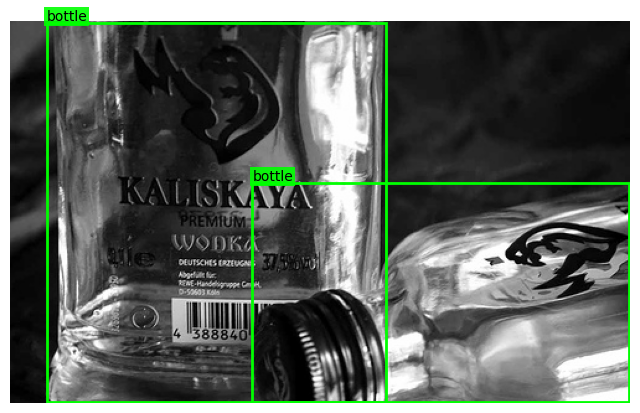

In [ ]:
# 1.1.2  Bounding box visualization

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

def visualize_bboxes(image_path: str,
                     boxes: np.ndarray,
                     class_names=VOC_CLASSES,
                     linewidth: int = 2,
                     save_path: str | None = None):
    """
    Overlay bounding boxes [class_id, x, y, w, h] on the original image.

    Returns
    -------
    (fig, ax) so you can further tweak if needed.
    """
    img = Image.open(image_path).convert("RGB")
    W, H = img.size

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)
    ax.axis("off")

    if boxes is None or len(boxes) == 0:
        plt.show()
        return fig, ax

    # Ensure integer boxes
    boxes = boxes.astype(int)

    for cid, x, y, w, h in boxes:
        # clip to image bounds (safety)
        x1 = max(0, x); y1 = max(0, y)
        x2 = min(W - 1, x + w); y2 = min(H - 1, y + h)
        w_clip = max(0, x2 - x1); h_clip = max(0, y2 - y1)

        rect = patches.Rectangle((x1, y1), w_clip, h_clip,
                                 linewidth=linewidth, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

        # label background
        label = class_names[cid] if 0 <= cid < len(class_names) else f"id:{cid}"
        ax.text(x1, y1 - 2, label,
                fontsize=10, color='black',
                bbox=dict(facecolor='lime', alpha=0.9, edgecolor='none', pad=1.5))

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()
    return fig, ax

# Pick one training sample and render its boxes
img_path, xml_path = train_set[0]
boxes = extract_bboxes_from_voc_xml(xml_path, skip_difficult=False)  # from 1.1.1
print("Boxes shape:", boxes.shape)  # (N, 5) -> [class_id, x, y, w, h]
_ = visualize_bboxes(img_path, boxes)

## 1.2 Classifier for “the presence of object”

### 1.2.1 Multi-hot encoding

In [ ]:
# 1.2.1  Multi-hot encoding of VOC classes for each image
# -------------------------------------------------------
def multi_hot_from_voc_xml(xml_path: str, *, skip_difficult: bool = False) -> np.ndarray:
    """
    Return a 20-dim multi-hot vector for this image.
    1 if the image contains at least one instance of that class, else 0.
    """
    y = np.zeros(len(VOC_CLASSES), dtype=np.int8)
    root = ET.parse(xml_path).getroot()

    for obj in root.findall("object"):
        if skip_difficult:
            d = obj.find("difficult")
            if d is not None and (d.text or "").strip() == "1":
                continue
        cls = (obj.findtext("name") or "").strip().lower()
        if cls in CLASS_TO_ID:
            y[CLASS_TO_ID[cls]] = 1
    return y

def build_multi_hot_labels(pairs, *, skip_difficult: bool = False) -> np.ndarray:
    """
    pairs: list of (img_path, xml_path)
    returns: array shape (N_images, 20) of {0,1}
    """
    Ys = [multi_hot_from_voc_xml(xml, skip_difficult=skip_difficult) for _, xml in pairs]
    return np.stack(Ys, axis=0) if Ys else np.zeros((0, len(VOC_CLASSES)), dtype=np.int8)

y_train = build_multi_hot_labels(train_set, skip_difficult=False)
y_val   = build_multi_hot_labels(val_set,   skip_difficult=False)

print("y_train shape:", y_train.shape)  # (N_train, 20)
print("y_val   shape:", y_val.shape)    # (N_val, 20)

def present_classes(vec):
    idx = np.where(vec == 1)[0].tolist()
    return idx, [VOC_CLASSES[i] for i in idx]

idx0, names0 = present_classes(y_train[0])
print("Train[0] classes:", names0)

# Label distribution (how many images contain each class in the split)
counts_train = y_train.sum(axis=0)
counts_val   = y_val.sum(axis=0)
print("\nClass counts in TRAIN:")
for c, n in zip(VOC_CLASSES, counts_train):
    print(f"{c:12s} {int(n)}")
print("\nClass counts in VAL:")
for c, n in zip(VOC_CLASSES, counts_val):
    print(f"{c:12s} {int(n)}")


y_train shape: (13700, 20)
y_val   shape: (3425, 20)
Train[0] classes: ['bottle']

Class counts in TRAIN:
aeroplane    572
bicycle      507
bird         663
boat         447
bottle       657
bus          382
car          1051
cat          889
chair        1100
cow          278
diningtable  548
dog          1069
horse        418
motorbike    455
person       7658
pottedplant  494
sheep        291
sofa         604
train        445
tvmonitor    512

Class counts in VAL:
aeroplane    144
bicycle      96
bird         148
boat         102
bottle       155
bus          85
car          233
cat          239
chair        266
cow          62
diningtable  143
dog          272
horse        108
motorbike    120
person       1925
pottedplant  119
sheep        66
sofa         138
train        144
tvmonitor    133


### 1.2.2 Training a Classifier

In [ ]:
import os, glob, time, random, math
import numpy as np
from typing import List, Tuple

# --- Torch / torchvision ---
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

# Pillow & parsing
from PIL import Image
import xml.etree.ElementTree as ET

# ------------------
# Device & settings
# ------------------
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", DEVICE)
BATCH_SIZE = 32                     # If OOM, reduce to 16
NUM_WORKERS = 0                     # Notebook-safe (avoid pickling)
EPOCHS = 8                          # Reasonable for homework; adjust as you like
IMG_SIZE_TRAIN = 192                # 224 -> 192 speeds up with minor accuracy cost
IMG_SIZE_VAL   = 192
GRAD_ACCUM = 1                      # Set >1 to simulate larger batch on limited RAM
CKPT_PATH = "voc_presence_mobilenetv3_best.pt"

# ---------------------------
# Dataset / DataLoader setup
# ---------------------------
class VOCPresenceDataset(Dataset):
    def __init__(self, pairs, labels, transform):
        self.pairs = pairs
        self.labels = labels.astype(np.float32)
        self.transform = transform
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img_path, _ = self.pairs[idx]
        y = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.from_numpy(y)

train_tf = T.Compose([
    T.Resize(int(IMG_SIZE_TRAIN*1.15)),
    T.RandomResizedCrop(IMG_SIZE_TRAIN, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tf = T.Compose([
    T.Resize(int(IMG_SIZE_VAL*1.15)),
    T.CenterCrop(IMG_SIZE_VAL),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = VOCPresenceDataset(train_set, y_train, train_tf)
val_ds   = VOCPresenceDataset(val_set,   y_val,   val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=False)


Using device: mps


In [ ]:
# -------------
# CNN backbone
# -------------
# MobileNetV3-Small = solid, fast CNN baseline (pretrained on ImageNet).
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 20)
model = model.to(DEVICE, memory_format=torch.channels_last)

# ----------------------------
# Loss with class imbalance
# ----------------------------
pos_counts = y_train.sum(axis=0).astype(np.float32) + 1e-6
neg_counts = len(y_train) - pos_counts
pos_weight = torch.tensor(neg_counts / pos_counts, dtype=torch.float32, device=DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# --------------------------
# Optimizer & LR scheduler
# --------------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---------------
# Metrics helper
# ---------------
@torch.no_grad()
def compute_metrics(logits: torch.Tensor, targets: torch.Tensor, threshold=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()

    eps = 1e-8
    tp = (preds * targets).sum(dim=0)
    fp = (preds * (1 - targets)).sum(dim=0)
    fn = ((1 - preds) * targets).sum(dim=0)

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1_per_class = 2 * precision * recall / (precision + recall + eps)
    macro_f1 = f1_per_class.mean().item()

    tp_s = (preds * targets).sum(dim=1)
    fp_s = (preds * (1 - targets)).sum(dim=1)
    fn_s = ((1 - preds) * targets).sum(dim=1)
    sample_f1 = (2 * tp_s / (2 * tp_s + fp_s + fn_s + eps)).mean().item()

    mAP = None
    try:
        from sklearn.metrics import average_precision_score
        mAP = average_precision_score(targets.cpu().numpy(), probs.cpu().numpy(),
                                      average='macro')
    except Exception:
        pass
    return {
        "macro_f1": macro_f1,
        "sample_f1": sample_f1,
        "f1_per_class": f1_per_class.cpu().tolist(),
        "mAP": mAP
    }

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /Users/user/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 5.49MB/s]


In [ ]:
# --------------------
# Training / Validation
# --------------------
best_val = -1.0
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train()
    tr_loss, n_batches = 0.0, 0

    optimizer.zero_grad(set_to_none=True)

    for step, (imgs, ys) in enumerate(train_loader, start=1):
        imgs = imgs.to(DEVICE, memory_format=torch.channels_last, non_blocking=False)
        ys = ys.to(DEVICE, non_blocking=False)

        # (AMP disabled on MPS)
        logits = model(imgs)
        loss = criterion(logits, ys) / GRAD_ACCUM
        loss.backward()

        if step % GRAD_ACCUM == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        tr_loss += float(loss.item()) * GRAD_ACCUM
        n_batches += 1

    scheduler.step()
    tr_loss /= max(1, n_batches)

    # ---- Validation ----
    model.eval()
    va_loss, n_batches = 0.0, 0
    all_logits, all_targets = [], []
    with torch.no_grad():
        for imgs, ys in val_loader:
            imgs = imgs.to(DEVICE, memory_format=torch.channels_last, non_blocking=False)
            ys = ys.to(DEVICE, non_blocking=False)
            logits = model(imgs)
            loss = criterion(logits, ys)
            va_loss += float(loss.item()); n_batches += 1
            all_logits.append(logits)
            all_targets.append(ys)

    va_loss /= max(1, n_batches)
    logits_cat  = torch.cat(all_logits,  dim=0)
    targets_cat = torch.cat(all_targets, dim=0)
    metrics = compute_metrics(logits_cat, targets_cat, threshold=0.5)

    elapsed = time.time() - t0
    msg = (f"[Epoch {epoch:02d}] "
           f"train_loss={tr_loss:.4f}  val_loss={va_loss:.4f}  "
           f"macroF1={metrics['macro_f1']:.4f}  sampleF1={metrics['sample_f1']:.4f}  "
           f"({elapsed:.1f}s)")
    if metrics["mAP"] is not None:
        msg += f"  mAP={metrics['mAP']:.4f}"
    print(msg)

    # Save best (prefer mAP if available; else macro-F1)
    score = metrics["mAP"] if metrics["mAP"] is not None else metrics["macro_f1"]
    if score > best_val:
        best_val = score
        torch.save(
            {"model": model.state_dict(),
             "epoch": epoch,
             "val_macroF1": metrics["macro_f1"],
             "val_mAP": metrics["mAP"]},
            CKPT_PATH
        )
        print(f"  ↳ Saved best checkpoint to {CKPT_PATH} (score={score:.4f})")

[Epoch 01] train_loss=0.6347  val_loss=0.5147  macroF1=0.4648  sampleF1=0.5857  (204.3s)  mAP=0.6561
  ↳ Saved best checkpoint to voc_presence_mobilenetv3_best.pt (score=0.6561)
[Epoch 02] train_loss=0.4556  val_loss=0.5004  macroF1=0.4544  sampleF1=0.5673  (161.3s)  mAP=0.6743
  ↳ Saved best checkpoint to voc_presence_mobilenetv3_best.pt (score=0.6743)
[Epoch 03] train_loss=0.3867  val_loss=0.5006  macroF1=0.4850  sampleF1=0.6109  (160.1s)  mAP=0.6815
  ↳ Saved best checkpoint to voc_presence_mobilenetv3_best.pt (score=0.6815)
[Epoch 04] train_loss=0.3280  val_loss=0.5167  macroF1=0.5400  sampleF1=0.6753  (159.2s)  mAP=0.6953
  ↳ Saved best checkpoint to voc_presence_mobilenetv3_best.pt (score=0.6953)
[Epoch 05] train_loss=0.2819  val_loss=0.5364  macroF1=0.5385  sampleF1=0.6736  (165.1s)  mAP=0.6964
  ↳ Saved best checkpoint to voc_presence_mobilenetv3_best.pt (score=0.6964)
[Epoch 06] train_loss=0.2535  val_loss=0.5784  macroF1=0.5678  sampleF1=0.6934  (159.3s)  mAP=0.7035
  ↳ Saved

In [ ]:
# ---- Load best checkpoint and evaluate once on the val set ----
import torch
from sklearn.metrics import average_precision_score

ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()
print(f"Loaded best checkpoint from {CKPT_PATH} (epoch={ckpt.get('epoch')}, "
      f"val_macroF1={ckpt.get('val_macroF1'):.4f}, val_mAP={ckpt.get('val_mAP')})")

# Collect logits/targets over the entire val set
all_logits, all_targets = [], []
with torch.no_grad():
    for imgs, ys in val_loader:
        imgs = imgs.to(DEVICE, memory_format=torch.channels_last)
        ys   = ys.to(DEVICE)
        logits = model(imgs)
        all_logits.append(logits)
        all_targets.append(ys)

logits_val  = torch.cat(all_logits,  dim=0)
targets_val = torch.cat(all_targets, dim=0)

metrics = compute_metrics(logits_val, targets_val, threshold=0.5)
print(f"Final @0.5  |  macroF1={metrics['macro_f1']:.4f}  "
      f"sampleF1={metrics['sample_f1']:.4f}  mAP={metrics['mAP']:.4f}")

probs_val = torch.sigmoid(logits_val).cpu().numpy()
y_true    = targets_val.cpu().numpy()
per_class_ap = []
for i, cname in enumerate(VOC_CLASSES):
    ap = average_precision_score(y_true[:, i], probs_val[:, i])
    per_class_ap.append((cname, float(ap)))
per_class_ap_sorted = sorted(per_class_ap, key=lambda x: x[1], reverse=True)
print("Top-5 classes by AP:", per_class_ap_sorted[:5])


Loaded best checkpoint from voc_presence_mobilenetv3_best.pt (epoch=8, val_macroF1=0.5777, val_mAP=0.7089568716851754)
Final @0.5  |  macroF1=0.5777  sampleF1=0.7059  mAP=0.7090
Top-5 classes by AP: [('person', 0.9747449554963287), ('train', 0.9387677900757863), ('cat', 0.900755174276264), ('aeroplane', 0.894042173949559), ('bus', 0.8735837641577854)]


## 1.3 RPN from scratch

In [ ]:
# ===============================
# 1.3  Region Proposal Network (RPN) from scratch
# ===============================
import os, math, time, random
from typing import List, Tuple

import numpy as np
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models
from torchvision.ops import nms

# -----------------
# Device / switches
# -----------------
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else
                      ("cuda" if torch.cuda.is_available() else "cpu"))
CHANNELS_LAST = True
print("RPN device:", DEVICE)

# -----------------------------
# Helper: VOC xml → boxes (xyxy)
# -----------------------------
def xywh_to_xyxy(boxes_np: np.ndarray) -> np.ndarray:
    if boxes_np.size == 0:
        return np.zeros((0,4), dtype=np.float32)
    x1 = boxes_np[:,1]
    y1 = boxes_np[:,2]
    x2 = x1 + boxes_np[:,3]
    y2 = y1 + boxes_np[:,4]
    return np.stack([x1,y1,x2,y2], axis=1).astype(np.float32)

def box_iou(boxes1: torch.Tensor, boxes2: torch.Tensor) -> torch.Tensor:
    # boxes: [N,4] [x1,y1,x2,y2]
    area1 = (boxes1[:,2]-boxes1[:,0]).clamp(min=0) * (boxes1[:,3]-boxes1[:,1]).clamp(min=0)
    area2 = (boxes2[:,2]-boxes2[:,0]).clamp(min=0) * (boxes2[:,3]-boxes2[:,1]).clamp(min=0)
    lt = torch.max(boxes1[:,None,:2], boxes2[:,:2])    # [N,M,2]
    rb = torch.min(boxes1[:,None,2:], boxes2[:,2:])    # [N,M,2]
    wh = (rb - lt).clamp(min=0)
    inter = wh[:,:,0] * wh[:,:,1]
    union = area1[:,None] + area2 - inter + 1e-6
    return inter / union

# -----------------------------------------------
# Dataset that RESIZES image and RESCALES GT boxes
# -----------------------------------------------
class VOCRPNDataset(Dataset):
    def __init__(self, pairs, target_short=800, max_long=1333):
        self.pairs = pairs
        self.target_short = target_short
        self.max_long = max_long
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225])

    def _resize_keep_ar(self, pil: Image.Image):
        w0, h0 = pil.size
        scale = self.target_short / min(w0, h0)
        if max(w0, h0) * scale > self.max_long:
            scale = self.max_long / max(w0, h0)
        new_w, new_h = int(round(w0 * scale)), int(round(h0 * scale))
        return pil.resize((new_w, new_h), Image.BILINEAR), (w0, h0, new_w, new_h)

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        img_path, xml_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")

        b = extract_bboxes_from_voc_xml(xml_path).astype(np.float32)  # [N,5]
        gt_xyxy = xywh_to_xyxy(b)  # original size

        img_resized, (w0, h0, w1, h1) = self._resize_keep_ar(img)
        sx, sy = w1 / w0, h1 / h0
        if gt_xyxy.size > 0:
            gt_xyxy[:, [0, 2]] *= sx
            gt_xyxy[:, [1, 3]] *= sy

        x = self.normalize(self.to_tensor(img_resized))
        return x, torch.tensor(gt_xyxy, dtype=torch.float32), torch.tensor([w1, h1], dtype=torch.float32), img_path

# ----------------------
# Build train/val loaders
# ----------------------
RPN_TRAIN_MAX = 2000
RPN_VAL_MAX   = 200

rpn_train_ds = VOCRPNDataset(train_set[:RPN_TRAIN_MAX] if RPN_TRAIN_MAX else train_set)
rpn_val_ds   = VOCRPNDataset(val_set[:RPN_VAL_MAX]     if RPN_VAL_MAX else val_set)

rpn_train_loader = DataLoader(rpn_train_ds, batch_size=1, shuffle=True,  num_workers=0)
rpn_val_loader   = DataLoader(rpn_val_ds,   batch_size=1, shuffle=False, num_workers=0)

# -------------------------------
# Feature extractor (frozen/eval)
# -------------------------------
use_mobilenet_from_1_2 = False
try:
    _ = model.features  # from 1.2.2 cell
    backbone = nn.Sequential(*list(model.features))  # copy the features
    feat_channels = 576  # MobileNetV3-Small last stage channels
    use_mobilenet_from_1_2 = True
    print("Using MobileNetV3-Small features from your trained classifier.")
except Exception:
    print("Falling back to ResNet-18 ImageNet-pretrained features.")
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    backbone = nn.Sequential(*(list(resnet.children())[:-2]))  # C5
    feat_channels = 512

backbone.eval().to(DEVICE)
if CHANNELS_LAST:
    backbone.to(memory_format=torch.channels_last)

# -----------------------------------------
# Anchors (location-major to match RPN head)
# -----------------------------------------
def generate_anchors(feat_h, feat_w, stride_xy, image_size,
                     scales=(32, 64, 128), ratios=(0.5, 1.0, 2.0)) -> torch.Tensor:
    """
    Location-major anchors so index mapping aligns with RPN head channels.
    Returns [A,4] (xyxy) clipped to image coords of the resized input.
    """
    device = DEVICE
    stride_x, stride_y = stride_xy

    shifts_x = torch.arange(feat_w, device=device, dtype=torch.float32) * float(stride_x) + float(stride_x)/2.0
    shifts_y = torch.arange(feat_h, device=device, dtype=torch.float32) * float(stride_y) + float(stride_y)/2.0
    centers_x = shifts_x.unsqueeze(0).expand(feat_h, feat_w)   # [Hf,Wf]
    centers_y = shifts_y.unsqueeze(1).expand(feat_h, feat_w)   # [Hf,Wf]
    centers   = torch.stack((centers_x, centers_y), dim=-1).reshape(-1, 2)  # [K,2]

    wh_list = []
    for s in scales:
        area = float(s) * float(s)
        for r in ratios:
            w = math.sqrt(area / float(r))
            h = w * float(r)
            wh_list.append((w, h))
    base_wh = torch.tensor(wh_list, device=device, dtype=torch.float32)  # [9,2]

    centers = centers.unsqueeze(1)              # [K,1,2]
    wh      = base_wh.unsqueeze(0)              # [1,9,2]
    xy1 = centers - wh/2.0
    xy2 = centers + wh/2.0
    anchors = torch.cat([xy1, xy2], dim=2).reshape(-1, 4)  # [K*9,4]

    W, H = image_size
    anchors[:, 0::2] = anchors[:, 0::2].clamp(0, float(W) - 1)
    anchors[:, 1::2] = anchors[:, 1::2].clamp(0, float(H) - 1)
    return anchors

# ---------------------------------
# Box coder (Faster R-CNN parameter)
# ---------------------------------
def encode_boxes(anchors, gt_boxes):
    wa = (anchors[:,2]-anchors[:,0]).clamp(min=1.)
    ha = (anchors[:,3]-anchors[:,1]).clamp(min=1.)
    xa = anchors[:,0] + 0.5*wa
    ya = anchors[:,1] + 0.5*ha

    wg = (gt_boxes[:,2]-gt_boxes[:,0]).clamp(min=1.)
    hg = (gt_boxes[:,3]-gt_boxes[:,1]).clamp(min=1.)
    xg = gt_boxes[:,0] + 0.5*wg
    yg = gt_boxes[:,1] + 0.5*hg

    tx = (xg - xa) / wa
    ty = (yg - ya) / ha
    tw = torch.log(wg / wa)
    th = torch.log(hg / ha)
    return torch.stack([tx,ty,tw,th], dim=1)

def decode_boxes(anchors, deltas):
    wa = (anchors[:,2]-anchors[:,0]).clamp(min=1.)
    ha = (anchors[:,3]-anchors[:,1]).clamp(min=1.)
    xa = anchors[:,0] + 0.5*wa
    ya = anchors[:,1] + 0.5*ha

    tx,ty,tw,th = deltas.unbind(dim=1)
    x = tx*wa + xa
    y = ty*ha + ya
    w = torch.exp(tw) * wa
    h = torch.exp(th) * ha

    x1 = x - 0.5*w
    y1 = y - 0.5*h
    x2 = x + 0.5*w
    y2 = y + 0.5*h
    return torch.stack([x1,y1,x2,y2], dim=1)

# ---------------------------------------
# Label assignment & subsampling per image
# ---------------------------------------
def assign_labels(anchors, gt_boxes, pos_iou=0.7, neg_iou=0.3,
                  topk_pos=256, topk_neg=256):
    N = anchors.size(0)
    labels = torch.full((N,), -1, dtype=torch.int64, device=anchors.device)
    bbox_targets = torch.zeros((N,4), dtype=torch.float32, device=anchors.device)

    if gt_boxes.numel() == 0:
        labels[:] = 0
        return labels, bbox_targets

    iou = box_iou(anchors, gt_boxes)  # [N,M]
    max_iou, argmax_iou = iou.max(dim=1)

    labels[max_iou < neg_iou] = 0
    labels[max_iou >= pos_iou] = 1

    # guarantee at least one positive per GT
    max_iou_per_gt, _ = iou.max(dim=0)
    gt_best_anchors = (iou == max_iou_per_gt.unsqueeze(0)).any(dim=1)
    labels[gt_best_anchors] = 1

    # subsample
    pos_idx = torch.where(labels == 1)[0]
    neg_idx = torch.where(labels == 0)[0]
    if len(pos_idx) > topk_pos:
        disable = pos_idx[torch.randperm(len(pos_idx), device=anchors.device)[topk_pos:]]
        labels[disable] = -1
    if len(neg_idx) > topk_neg:
        disable = neg_idx[torch.randperm(len(neg_idx), device=anchors.device)[topk_neg:]]
        labels[disable] = -1

    # bbox targets for positives
    pos_idx = torch.where(labels == 1)[0]
    if len(pos_idx) > 0:
        matched_gt = gt_boxes[argmax_iou[pos_idx]]
        bbox_targets[pos_idx] = encode_boxes(anchors[pos_idx], matched_gt)
    return labels, bbox_targets

# ---------------
# RPN Head module
# ---------------
class RPNHead(nn.Module):
    def __init__(self, in_channels, num_anchors=9, pi=0.01):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 256, 3, padding=1)
        self.cls_logits = nn.Conv2d(256, num_anchors, 1)
        self.bbox_pred  = nn.Conv2d(256, num_anchors*4, 1)

        for l in [self.conv, self.cls_logits, self.bbox_pred]:
            nn.init.normal_(l.weight, std=0.01)
            nn.init.constant_(l.bias, 0.)

        # Prior prob for foreground (stabilizes early training)
        bias_value = -math.log((1 - pi) / pi)
        nn.init.constant_(self.cls_logits.bias, bias_value)

    def forward(self, x):
        t = F.relu(self.conv(x))
        logits = self.cls_logits(t)   # [B,k,H,W]
        deltas = self.bbox_pred(t)    # [B,4k,H,W]
        return logits, deltas

rpn_head = RPNHead(in_channels=feat_channels, num_anchors=9).to(DEVICE)
if CHANNELS_LAST:
    rpn_head.to(memory_format=torch.channels_last)

# -------------------
# Loss & proposal gen
# -------------------
def rpn_loss(objectness_logits, bbox_deltas, labels, bbox_targets):
    valid = labels != -1
    obj_loss = (F.binary_cross_entropy_with_logits(objectness_logits[valid].float(),
                                                   labels[valid].float())
                if valid.any() else torch.tensor(0., device=labels.device))
    pos = labels == 1
    reg_loss = (F.smooth_l1_loss(bbox_deltas[pos], bbox_targets[pos], beta=1/9)
                if pos.any() else torch.tensor(0., device=labels.device))
    return obj_loss, reg_loss

def generate_proposals(anchors, obj_logits, bbox_deltas, image_size,
                       score_thresh=0.7, pre_nms_topk=1200, post_nms_topk=200,
                       nms_thresh=0.7, min_size=16):
    probs = torch.sigmoid(obj_logits).detach()

    # Score threshold first to kill clutter
    keep = probs >= score_thresh
    if keep.sum() == 0:
        return torch.empty((0,4)), torch.empty((0,))

    probs = probs[keep]
    anchors = anchors[keep]
    bbox_deltas = bbox_deltas[keep]

    # pre-NMS topK
    num_topk = min(pre_nms_topk, probs.numel())
    scores, idx = probs.topk(num_topk, sorted=True)
    sel_anchors = anchors[idx]
    sel_deltas  = bbox_deltas[idx]

    # decode
    boxes = decode_boxes(sel_anchors, sel_deltas)

    # clip & min-size
    W,H = image_size
    boxes[:,0::2] = boxes[:,0::2].clamp(0, W-1)
    boxes[:,1::2] = boxes[:,1::2].clamp(0, H-1)
    ws = (boxes[:,2]-boxes[:,0])
    hs = (boxes[:,3]-boxes[:,1])
    keep = (ws >= min_size) & (hs >= min_size)
    boxes = boxes[keep]; scores = scores[keep]

    if boxes.numel() == 0:
        return torch.empty((0,4)), torch.empty((0,))

    # NMS on CPU for compatibility
    keep_idx = nms(boxes.cpu(), scores.cpu(), nms_thresh)
    keep_idx = keep_idx[:post_nms_topk]
    return boxes.cpu()[keep_idx], scores.cpu()[keep_idx]

# -------------------------------------
# Forward pass (train) for a single img
# -------------------------------------
def rpn_forward_train(img_t, gt_boxes_xyxy):
    with torch.no_grad():
        feats = backbone(img_t.to(DEVICE).unsqueeze(0))
    if CHANNELS_LAST:
        feats = feats.to(memory_format=torch.channels_last)
    _, _, Hf, Wf = feats.shape
    H, W = img_t.shape[-2:]
    stride_x = W / Wf
    stride_y = H / Hf

    anchors = generate_anchors(Hf, Wf, (stride_x, stride_y), (W, H))
    logits, bbox_pred = rpn_head(feats)                 # [1,k,Hf,Wf], [1,4k,Hf,Wf]
    obj_logits = logits.permute(0,2,3,1).reshape(-1)    # [A]
    deltas     = bbox_pred.permute(0,2,3,1).reshape(-1,4)  # [A,4]

    labels, targets = assign_labels(anchors, gt_boxes_xyxy.to(DEVICE))
    obj_loss, reg_loss = rpn_loss(obj_logits, deltas, labels, targets)
    return obj_loss, reg_loss

@torch.no_grad()
def rpn_infer_proposals(img_t, score_thresh=0.7):
    feats = backbone(img_t.to(DEVICE).unsqueeze(0))
    if CHANNELS_LAST:
        feats = feats.to(memory_format=torch.channels_last)
    _, _, Hf, Wf = feats.shape
    H, W = img_t.shape[-2:]
    stride_x = W / Wf
    stride_y = H / Hf

    anchors = generate_anchors(Hf, Wf, (stride_x, stride_y), (W, H))
    logits, bbox_pred = rpn_head(feats)
    obj_logits = logits.permute(0,2,3,1).reshape(-1)
    deltas     = bbox_pred.permute(0,2,3,1).reshape(-1,4)
    props, scores = generate_proposals(anchors, obj_logits, deltas, (W, H),
                                       score_thresh=score_thresh)
    return props, scores, (W, H)


RPN device: mps
Using MobileNetV3-Small features from your trained classifier.


In [57]:
# -------------
# Train the RPN
# -------------
EPOCHS_RPN = 3
rpn_optimizer = torch.optim.AdamW(rpn_head.parameters(), lr=1e-4, weight_decay=1e-4)

rpn_head.train()
for epoch in range(1, EPOCHS_RPN + 1):
    t0 = time.time()
    losso = lossr = 0.0
    nb = 0
    for img_t, gt, _, _ in rpn_train_loader:
        img_t = img_t.squeeze(0)  # batch = 1
        gt = gt.squeeze(0)
        obj_loss, reg_loss = rpn_forward_train(img_t, gt)
        loss = obj_loss + reg_loss

        rpn_optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(rpn_head.parameters(), 5.0)
        rpn_optimizer.step()

        losso += float(obj_loss.item())
        lossr += float(reg_loss.item())
        nb += 1

    print(f"[RPN Epoch {epoch}] obj_loss={losso/max(1,nb):.4f}  reg_loss={lossr/max(1,nb):.4f}  ({time.time()-t0:.1f}s)")



[RPN Epoch 1] obj_loss=0.2850  reg_loss=1.1496  (339.7s)
[RPN Epoch 2] obj_loss=0.2181  reg_loss=1.4131  (326.7s)
[RPN Epoch 3] obj_loss=0.2121  reg_loss=1.7606  (305.5s)


2008_004649.jpg | proposals: 106 | GT: 2


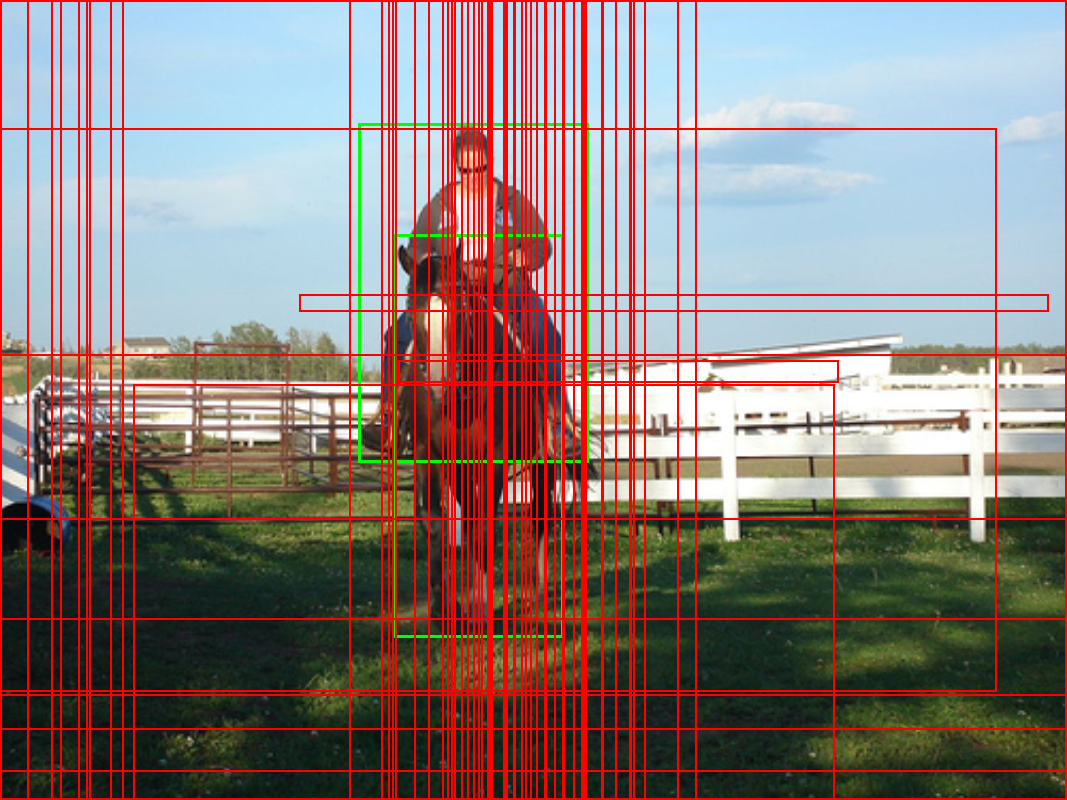

2008_000950.jpg | proposals: 147 | GT: 2


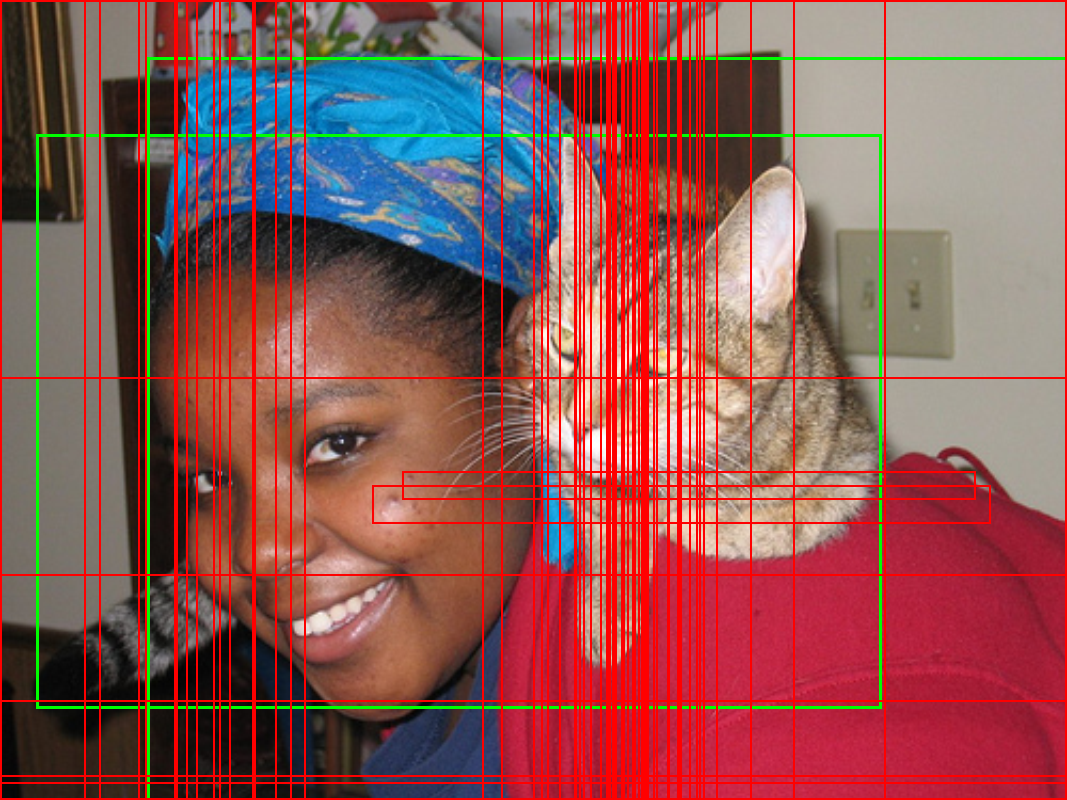

2012_003961.jpg | proposals: 162 | GT: 1


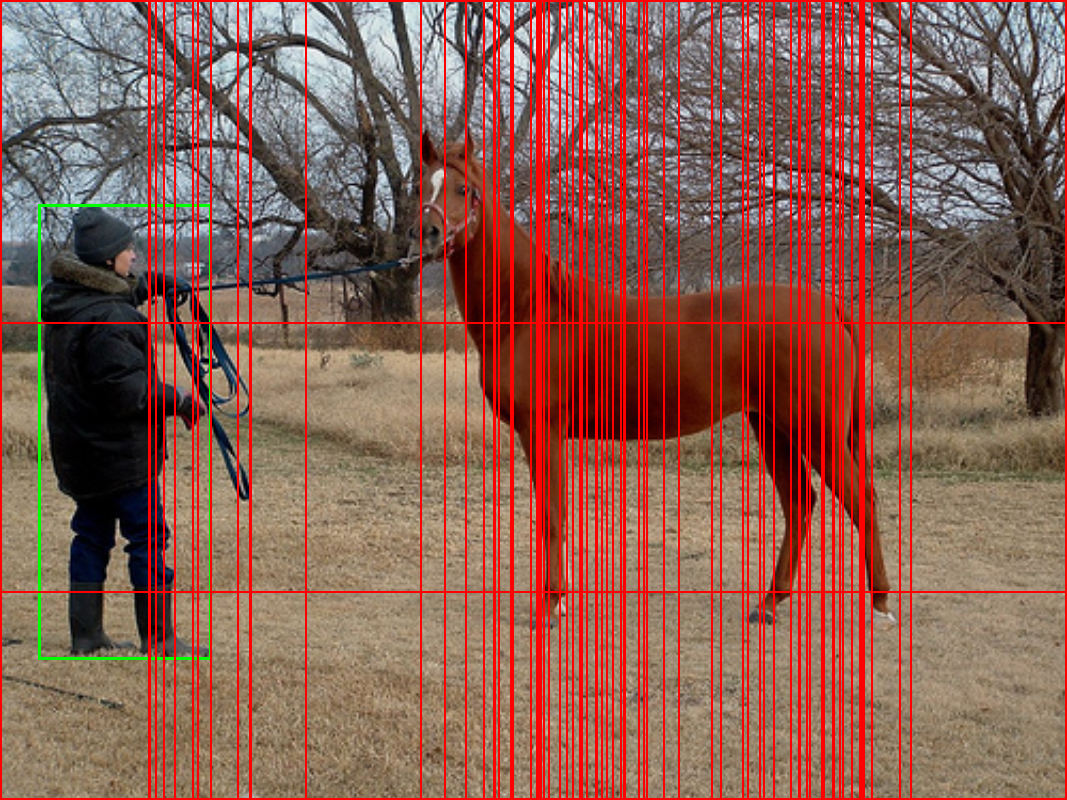

In [ ]:
# -----------------------------
# Visualization
# -----------------------------
def visualize_rpn_result_resized(img_path: str, proposals: torch.Tensor, gt_boxes: torch.Tensor,
                                 max_show=50):
    """
    Draw on the **resized** image (the same coordinate frame used by the RPN).
    We reconstruct the same resize used in the dataset for consistent scaling.
    """
    img = Image.open(img_path).convert("RGB")
    # redo the dataset's resize
    w0, h0 = img.size
    scale = 800 / min(w0, h0)
    if max(w0, h0) * scale > 1333:
        scale = 1333 / max(w0, h0)
    new_w, new_h = int(round(w0 * scale)), int(round(h0 * scale))
    img = img.resize((new_w, new_h), Image.BILINEAR)

    draw = ImageDraw.Draw(img)
    # GT in green
    for (x1,y1,x2,y2) in gt_boxes.cpu().numpy().astype(int):
        draw.rectangle([x1,y1,x2,y2], outline=(0,255,0), width=3)
    # Proposals (post-NMS, score-thresholded) in red
    n = min(max_show, len(proposals))
    for (x1,y1,x2,y2) in proposals[:n].cpu().numpy().astype(int):
        draw.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=2)

    display(img)

# quick qualitative check
rpn_head.eval()
for i, (img_t, gt, _, img_path) in enumerate(rpn_val_loader):
    img_t = img_t.squeeze(0)
    gt = gt.squeeze(0)
    props, scores, _ = rpn_infer_proposals(img_t, score_thresh=0.8)
    print(os.path.basename(img_path[0]), f"| proposals: {len(props)} | GT: {gt.shape[0]}")
    visualize_rpn_result_resized(img_path[0], props, gt, max_show=40)
    if i >= 2:
        break